# Agent based Grid simulation

In [1]:
%matplotlib notebook
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import sys

In [58]:
Nx, Ny = 15, 15
dim = (Nx,Ny)
space = np.zeros(dim)
npr.seed(42)

def periodic_dist(r,N):
    # Computes distance for periodic boundary conditions in one direction
    # r: non periodic distance
    # N: Periodicity in direction r
    if r > N or r < -N:
        raise Exception("Invalid Input, r cannot be lower or higher than N")
    if r > N/2:
        return r - N
    elif r < -N/2:
        return r + N
    elif np.abs(r) == N/2:
        return r if npr.rand() < 0.5 else -r  # If this clause would not exists the agent would always choose to "not go over the edge"
    else:
        return r

class Agent:
    trajectories = []
    times = []
    #steps = []

    def __init__(self, init_pos, goal, init_time):
        self.dir = npr.randint(2)  # Directional preference (if 0 first x & if 1 first y)
        self.pos = init_pos.copy()
        self.goal = goal
        self.steps = 0
        self.init = init_pos
        self.init_time = init_time
        self.trajectory = [init_pos.copy()]

    def step(self):
        self.steps += 1
 
        if np.any(self.pos != self.goal):
            diff_x = periodic_dist(self.goal[0] - self.pos[0], Nx)
            diff_y = periodic_dist(self.goal[1] - self.pos[1], Ny)

            if diff_x != 0 and self.dir == 0:
                self.pos[0] = (self.pos[0] + np.sign(diff_x)) % Nx
            elif diff_y != 0 and self.dir == 1:
                self.pos[1] = (self.pos[1] + np.sign(diff_y)) % Ny
            elif diff_x != 0:
                self.pos[0] = (self.pos[0] + np.sign(diff_x)) % Nx
            elif diff_y != 0:
                self.pos[1] = (self.pos[1] + np.sign(diff_y)) % Ny
            else:
                raise Exception('This should not happen')
       
        self.trajectory.append(self.pos.copy())
        if np.all(self.pos == self.goal):
            Agent.trajectories.append(np.concatenate(self.trajectory).reshape(len(self.trajectory),2))
            Agent.times.append(self.init_time)
            #Agent.steps.append(self.steps)
            return True
        else:
            return False


agents_per_step = Nx*Ny
mean_travel_dist = 5
range_travel_dist = 2
sum_dists = 0
T_max = 1000
time = np.arange(0,T_max)
test_space = np.zeros(dim)
test_space2 = np.zeros(dim)

agents = []

for t in time:
    sys.stdout.write('\r'+'t = {}/{}'.format(t+1,T_max))
    new_agents = []
    for i in range(agents_per_step):
        start = npr.randint(dim)
        rnd_travel_dist = npr.randint(mean_travel_dist-range_travel_dist,
                                      mean_travel_dist+range_travel_dist+1)
        sum_dists += rnd_travel_dist
        x_dist = npr.randint(-rnd_travel_dist, rnd_travel_dist+1)
        y_dist = npr.choice([-1,1]) * (rnd_travel_dist - np.abs(x_dist))
        goal = (start + np.array([x_dist, y_dist])) % np.array([Nx,Ny])
        new_agents.append(Agent(start, goal, t))
    agents.extend(new_agents)
    for i,agent in reversed(list(enumerate(agents))):  # Traverse reversed to not change list while iterating
        space[tuple(agent.pos)] += 1
        finished = agent.step()
        if finished == True:
            if agent.steps > mean_travel_dist+range_travel_dist:
                print('should not happen', agent.steps)
            agents.pop(i)

print('\nActual average travel dist: ', sum_dists/(T_max*agents_per_step))

t = 1000/1000
Actual average travel dist:  4.9992133333333335


# Plotting of individual trajectories

<IPython.core.display.Javascript object>


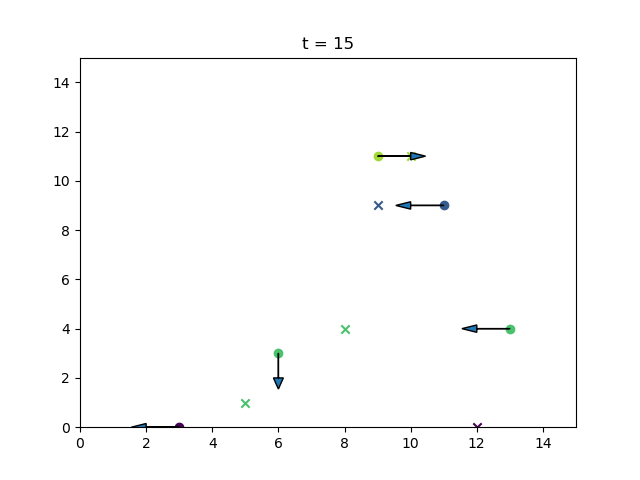

In [59]:
import logging
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.colors import to_hex

# trajectories = np.stack(Agent.trajectories)
trajectories = Agent.trajectories
travel_dists = np.array([len(traj) for traj in trajectories]) - 1
start_times = np.array(Agent.times)
unique_times = start_times[::agents_per_step]
unique_trajectories = trajectories[::agents_per_step]
unique_dists = travel_dists[::agents_per_step]
colors = npr.permutation(unique_times / unique_times.max())
viridis = cm.get_cmap("viridis", 8)

def init():
    ax.set_xlim(0, Nx)
    ax.set_ylim(0, Ny)

fig, ax = plt.subplots()

def anim(i):
    ax.clear()
    idx = np.where(((unique_times + unique_dists) > i) & (unique_times < i))[0]
    # c_now = [viridis(colors[j]) for j in idx]
    for j in idx:
        ax.scatter(
            unique_trajectories[j][-1,0],
            unique_trajectories[j][-1,1],
            marker="x",
            color=viridis(colors[j]),
        )
        ax.scatter(
            unique_trajectories[j][i - unique_times[j],0],
            unique_trajectories[j][i - unique_times[j],1],
            marker="o",
            color=viridis(colors[j]),
        )
        ax.arrow(
            unique_trajectories[j][i - unique_times[j],0],
            unique_trajectories[j][i - unique_times[j],1],
            unique_trajectories[j][i - unique_times[j] + 1,0]
            - unique_trajectories[j][i - unique_times[j],0],
            unique_trajectories[j][i - unique_times[j] + 1,1]
            - unique_trajectories[j][i - unique_times[j],1],
            head_width=0.3,
        )
    ax.set_xlim(0, Nx)
    ax.set_ylim(0, Ny)
    ax.set_title("t = {}".format(i))


animate = FuncAnimation(fig, anim, interval=500)# , init_func=init)
plt.show()

# Occupation matrix of stations and mean occupation of stations

Mean occupation of each station:  4.988066666666667


<IPython.core.display.Javascript object>


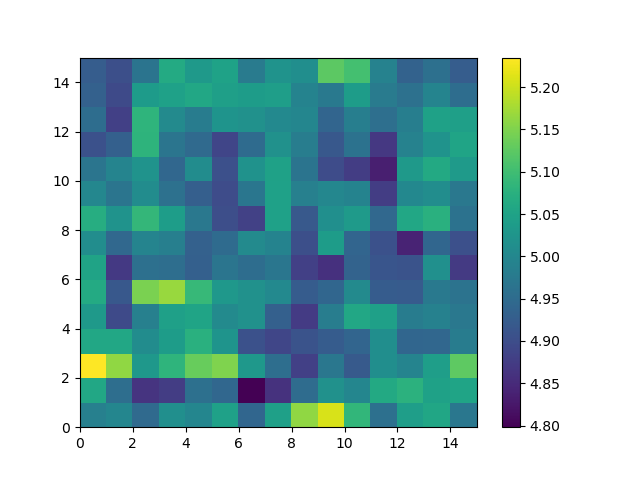

In [60]:
print('Mean occupation of each station: ', (space/T_max).mean())
#print('Occupation of stops per cell\n', space/T_max)

plt.pcolor(space/T_max)
plt.colorbar()
plt.show()

# Old plotting for constant travel dists

In [56]:
# import logging
# from matplotlib.animation import FuncAnimation
# from matplotlib import cm
# from matplotlib.colors import to_hex

# #trajectories = np.stack(Agent.trajectories)
# trajectories = Agent.trajectories
# start_times = np.array(Agent.times)
# unique_times = start_times[::agents_per_step]
# unique_trajectories = trajectories[::agents_per_step]
# colors = npr.permutation(unique_times/unique_times.max())
# viridis = cm.get_cmap('viridis', 8)


# def init():
#     ax.set_xlim(0, Nx)
#     ax.set_ylim(0, Ny)


# def anim(i):
#     ax.clear()
#     idx = np.where((unique_times > (i - travel_dist)) & (unique_times < i))[0]
#     c_now = [viridis(colors[j]) for j in idx]
#     ax.scatter(unique_trajectories[idx,-1,0], unique_trajectories[idx,-1,1],
#                marker='x', c=c_now)
#     ax.scatter(
#         unique_trajectories[idx, i - unique_times[idx], 0],
#         unique_trajectories[idx, i - unique_times[idx], 1],
#         marker="o", color=c_now
#     )
#     for j in idx:
#         ax.arrow(
#             unique_trajectories[j, i - unique_times[j], 0],
#             unique_trajectories[j, i - unique_times[j], 1],
#             unique_trajectories[j, i - unique_times[j] + 1, 0]
#             - unique_trajectories[j, i - unique_times[j], 0],
#             unique_trajectories[j, i - unique_times[j] + 1, 1]
#             - unique_trajectories[j, i - unique_times[j], 1], head_width=0.3
#         )
#     ax.set_xlim(0, Nx)
#     ax.set_ylim(0, Ny)
#     ax.set_title("t = {}".format(i))


# fig, ax = plt.subplots()
# # ax.set_xlim([0,10])
# # ax.set_ylim([0,10])
# animate = FuncAnimation(fig, anim, interval=500)  # , init_func=init)
# plt.show()